# SVM

## Linear SVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

In [2]:
train_X = np.array([
    [6, -8],
    [6.5, -9],
    [9, -8.5],
    [6.5, -9],
    [5, -2.5],
    [8, -4],
    [9.5, -4],
    [9, -5],
])
train_y = np.array([1, 1, 1, 1, -1, -1, -1, -1])

test_X = np.array([
    [5, -7],
    [5.5, -9],
    [8, -8],
    [9, -8],
    [7, -2.5],
    [8, -5],
    [5, -5],
    [6.5, -4],
])
test_y = np.array([1, 1, 1, 1, -1, -1, -1, -1])

m = train_X.shape[0]

### Model

In [3]:
clf = svm.SVC(kernel='linear')
clf.fit(train_X, train_y)

SVC(kernel='linear')

In [4]:
"""
clf.dual_coef_[i] = labels[i] * alphas[i]
where labels[i] is either -1 or +1 and alphas[i] are always positive.
"""
alpha = np.zeros((m,))
alpha[clf.support_] = np.abs(clf.dual_coef_)
print(f"alpha: {alpha}")
print(f"w: {clf.coef_}, intercept: {clf.intercept_}")
print(f"support vectors with idx {clf.support_}:\n{clf.support_vectors_}")

alpha: [0.03172284 0.         0.1360743  0.         0.         0.
 0.         0.16779714]
w: [[-0.09516853 -0.57142857]], intercept: [-3.00055654]
support vectors with idx [7 0 2]:
[[ 9.  -5. ]
 [ 6.  -8. ]
 [ 9.  -8.5]]


In [5]:
# analytical solution
def optimal_solution(X, y, alpha):
    w = sum((alpha[i] * y[i] * X[i]) for i in range(m))
    S_len = clf.support_.shape[0]
    b = sum((1 / y[idx] - w.T @ x_s) for idx, x_s in zip(clf.support_, clf.support_vectors_)) / S_len
    return (w, b)
w_test, b_test = optimal_solution(train_X, train_y, alpha)
print(f'w:{w_test}, equal={np.isclose(clf.coef_, w_test)}\nb:{b_test}, equal={np.isclose(clf.intercept_, b_test)}')

w:[-0.09516853 -0.57142857], equal=[[ True  True]]
b:-3.000556541097076, equal=[ True]


### Test Set

In [6]:
test_pred = clf.predict(test_X)
print(test_pred)

[ 1  1  1  1 -1 -1 -1 -1]


In [7]:
def linear_svm_predict(X: np.array):
    raw = np.apply_along_axis(lambda x: w_test.T @ x + b_test, axis=1, arr=X)
    print(raw)
    return np.sign(raw)
print(linear_svm_predict(test_X))

[ 0.52360082  1.6188737   0.80952381  0.71435528 -2.23816481 -0.9047619
 -0.61925632 -1.33343768]
[ 1.  1.  1.  1. -1. -1. -1. -1.]


### Evaluation

In [8]:
clf.score(test_X, test_y)

1.0

### Plot

In [9]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    s=100, linewidth=1, facecolors='none',edgecolors='k')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

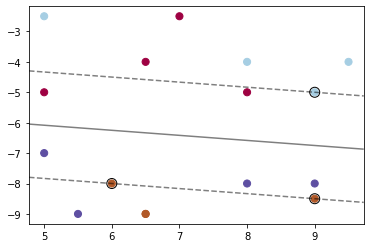

In [10]:
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=50, cmap=plt.cm.Paired)
plt.scatter(test_X[:, 0], test_X[:, 1], c=test_y, s=50, cmap=plt.cm.Spectral)
plot_svc_decision_function(clf, plot_support=True)

## Kernel & Soft Margin SVM

The SVM model uses a 2-degree polynomial kernel, and a regularization parameter C=1 for the soft-margin penalty item.

The kernel function is chosen by observing the data shape in scatter plot, and C is determined from testing.

The SVM model achieved 92% accuracy on the test set.

### Data

In [11]:
import pandas as pd

train = pd.read_csv("data/SVM/training.csv")
test = pd.read_csv("data/SVM/test.csv")

train_X = train[["x_1", "x_2"]].values
train_y = train["y"].values
test_X = test[["x_1", "x_2"]].values
test_y = test["y"].values

### Model

In [12]:
best_C = 1
best_score = 0
for C in np.arange(0.1, 10, 0.1):
    clf = svm.SVC(kernel='poly', degree=2, C=C).fit(train_X, train_y)
    score = clf.score(test_X, test_y)
    if score > best_score:
        best_C = C
        best_score = score
print(f'Best C is {best_C} with score {best_score}')

Best C is 0.2 with score 0.92


In [13]:
clf = svm.SVC(kernel='poly', degree=2, C=best_C)
clf.fit(train_X, train_y)

SVC(C=0.2, degree=2, kernel='poly')

### Plot

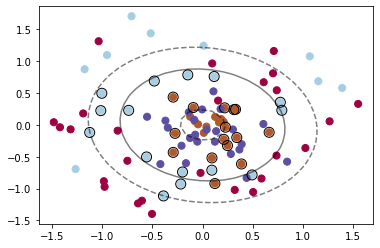

In [14]:
# Plot train and test data
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=50, cmap=plt.cm.Paired)
plt.scatter(test_X[:, 0], test_X[:, 1], c=test_y, s=50, cmap=plt.cm.Spectral)

# Plot decision function
plot_svc_decision_function(clf, plot_support=True)

### Evaluation

In [15]:
print(f'Accuracy: {clf.score(test_X, test_y)}')

Accuracy: 0.92
